## Проект: Cookie Cats

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pingouin as pg

### 1. Предварительный анализ данных.

In [3]:
cats_df = pd.read_csv('data/cookie_cats.csv')
cats_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
# Размерность данных
cats_df.shape

(90189, 5)

In [5]:
# Типы данных
cats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
# Проверим пользователей на уникальность
cats_df.userid.nunique() == cats_df.shape[0]

True

In [7]:
# Описательные статистики для sum_gamerounds
cats_df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

В датасете 90189 записей, типы данных корректны и соответствуют логике датасета, пропусков нет, все пользователи уникальны.

Количество сыгранных раундов от 0 до 49854. Это говорит о том, что часть пользователей после установки не играли вообще, и в данных, скорее всего есть выбросы, так как невозможно за 14 дней набрать 49854 раунда.

Исследуем этот признак подробнее.

In [8]:
not_playing = cats_df.query('sum_gamerounds == 0').shape[0]
not_playing_perc = not_playing / cats_df.shape[0] * 100
print(f'Не играли после установки {not_playing} пользователей,')
print(f'что составляет {not_playing_perc:.2f}% от общего их числа.')

Не играли после установки 3994 пользователей,
что составляет 4.43% от общего их числа.


Поскольку мы исследуем влияние установки ворот на 30 либо 40 уровне, пользователи, вообще не заходившие в игру не влияют на результат. 

Исключим их из данных.

In [9]:
clear_df = cats_df.query('sum_gamerounds != 0')

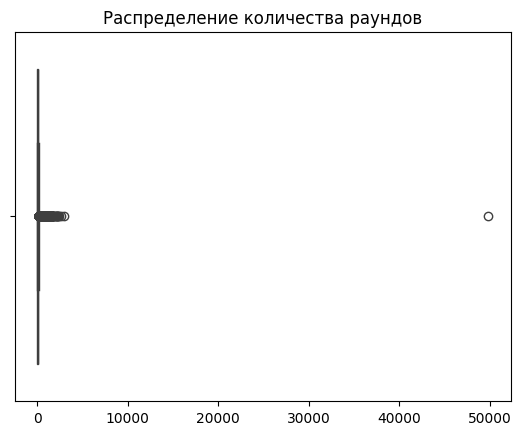

In [10]:
# Посмотрим на выбросы в данных
sns.boxplot(clear_df.sum_gamerounds, orient='h')
plt.title('Распределение количества раундов')
plt.xlabel('')
plt.show()

Очевидно, что в данных есть один выброс, удалим его.

Посмотрим на описательные статистики и распределение раундов в очищенных данных

In [11]:
clear_df = clear_df.query('sum_gamerounds != 49854')

In [12]:
clear_df.sum_gamerounds.describe()

count    86194.000000
mean        53.698297
std        104.425174
min          1.000000
25%          6.000000
50%         18.000000
75%         54.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

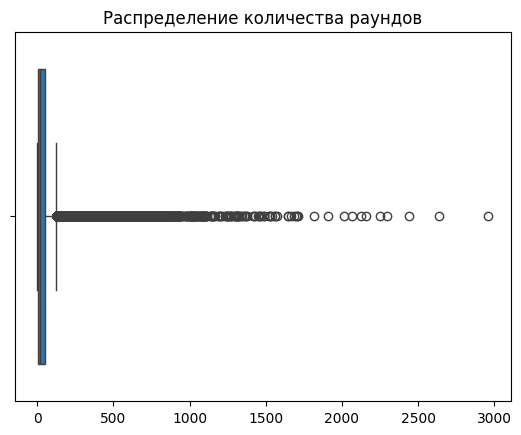

In [13]:
sns.boxplot(clear_df.sum_gamerounds, orient='h')
plt.title('Распределение количества раундов')
plt.xlabel('')
plt.show()

Визуально видно, что распределение количества раундов отличается от нормального, но мы проверим это дальше. Экстремальные значения свыше 2000 нельзя считать выбросами, так как вполе возможно сыграть около 200 раундов в день.

Посмотрим на то, как пользователи были распределены по группам и нет ли в группах пересечений пользователей.

In [15]:
clear_df.groupby('version', as_index=False).userid.count()

,version,userid
0,gate_30,42762
1,gate_40,43432


Пользователи распределены примерно поровну.

In [16]:
# Разделим пользователей на группы
gr_A = clear_df.query('version == "gate_30"')
gr_B = clear_df.query('version == "gate_40"')
# Проверим на пересечение пользователей
set(gr_A.userid).intersection(set(gr_B.userid))

set()

Пересечений пользователей между группами нет.

### 2. Анализ результатов A/B-тестирования.

Для анализа результатов мы посмотрим на изменение `retention`. Это основная метрика для данного набора данных, так как мы проверяем именно продолжающийся интерес к игре. Другими релевантными метриками были бы, например, количество покупок, APRU, ARPPU, CR в покупку, но у нас нет данных для такого анализа.

Также мы сравним количество сыгранных раундов в обеих группах.

#### 2.1. Сравнение количества сыгранных раундов

Для выбора теста необходимо проверить выборки групп на нормальность и равенство дисперсий. Если распределения нормальны и дисперсии равны, мы сможем применить t-test. 

Для всех проводимых тестов здесь и далее задаем уровень значимости `alpha` = 0.05

Проверим выборки на нормальность методом Шапиро-Уилка.

* Нулевая гипотеза: распределения нормальны.
* Альтернативная гипотеза: распределения не являются нормальными.

In [17]:
pg.normality(data=clear_df, dv='sum_gamerounds', group='version')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/distribution.py:221: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 42762.
  stats = pd.DataFrame(func(data)).T
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/distribution.py:221: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 43432.
  stats = pd.DataFrame(func(data)).T


,W,pval,normal
version,,,
gate_30,0.494894,9.655150e-138,False
gate_40,0.489150,1.619190e-138,False


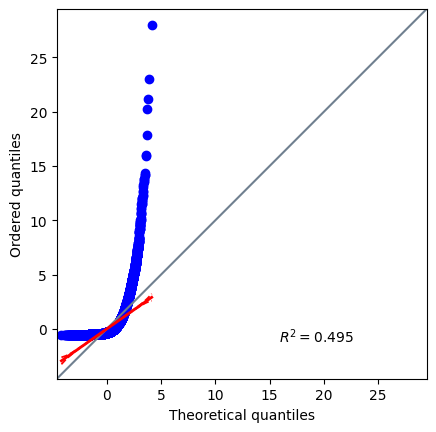

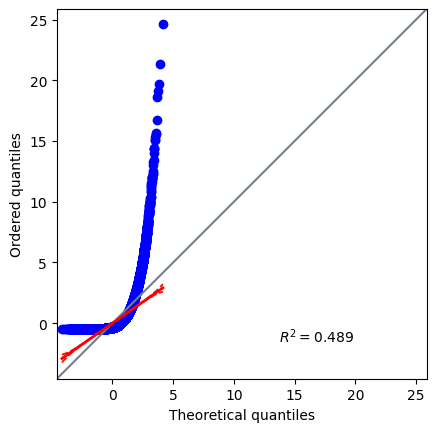

In [18]:
# Построим графики QQ-plot для дополнительной визуализации
pg.qqplot(gr_A.sum_gamerounds)
plt.show()
pg.qqplot(gr_B.sum_gamerounds)
plt.show()


Тест Шапиро-Уилка показал значение p-value очень близкие к нулю для обеих групп, следовательно мы отвергаем нулевую гипотезу о нормальности распределений. Графики QQ-plots подтверждают, что распределения очень далеки от нормальных.

Проведем тест Левена на равенство дисперсий.

* Нулевая гипотеза: дисперсии в выборках равны.
* Альтернативная гипотеза: дисперсии не равны.

In [19]:
pg.homoscedasticity(data=clear_df, dv='sum_gamerounds', group='version')

,W,pval,equal_var
levene,0.159666,0.689465,True


Тест Левена показал, что pvalue выше заданного уровня значимости, следовательно у нас нет оснований отвергнуть нулевую гипотезу о равенстве дисперсий.

Поскольку распределения в сильно отличаются от нормальных, мы не можем использовать t-test для сравнения средних.

Я буду использовать bootstrap для сравнения среднего количества сыгранных раундов.

Сначала рассчитаем среднее для групп:

In [22]:
clear_df.groupby('version').sum_gamerounds.mean()

version
gate_30    53.667766
gate_40    53.728357
Name: sum_gamerounds, dtype: float64

По имеющимся данным средние в группах различаются в десятых.

Рассчитаем доверительные интервалы и сравним их.

* Нулевая гипотеза: средние в группах равны
* Альтернативная гипотеза: средние в группах различаются.

In [24]:
# Доверительные интервалы для среднего контрольной и тестовой групп
ci_A = pg.compute_bootci(gr_A.sum_gamerounds.values, seed=42,
                         func='mean', n_boot=1000, return_dist=True)
ci_B = pg.compute_bootci(gr_B.sum_gamerounds.values, seed=42,
                         func='mean', n_boot=1000, return_dist=True)
print(f'Доверительный интервал группы А: {ci_A[0]}')
print(f'Доверительный интервал группы B: {ci_B[0]}')

Доверительный интервал группы А: [52.71 54.71]
Доверительный интервал группы B: [52.78 54.85]


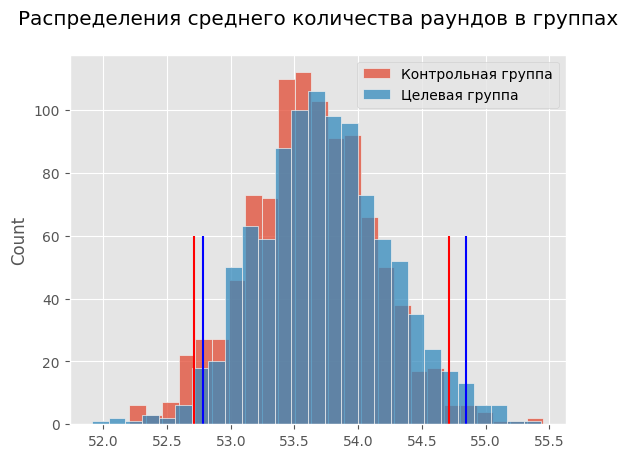

In [38]:
# Визуализируем получившиеся распределения
sns.histplot(ci_A[1], label='Контрольная группа')
sns.histplot(ci_B[1], label='Целевая группа')
plt.vlines(ci_A[0], ymin=0, ymax=60, colors='r')
plt.vlines(ci_B[0], ymin=0, ymax=60, colors='b')
plt.title('Распределения среднего количества раундов в группах\n')
plt.xlabel('')
plt.legend()
plt.show()

Мы видим, что распределения средних количества раундов практически наложились друг на друга. Для ясности рассчитаем с помощью bootstrap доверительные интервалы для разницы средних.

In [40]:
def mean_diff(x, y):
    """Функция рассчитывает разницу средних
    для последующего использования в pg.compute_bootci

    Args:
        x (pd.Series): Первая выборка для сравнения
        y (pd.Series): Вторая выборка для сравнения

    Returns:
        numpy.float64: Разница между средними значениями в выборках
    """
    return np.mean(x) - np.mean(y)

# Рассчитываем доверительный интервал для разницы средних
ci = pg.compute_bootci(gr_A.sum_gamerounds, gr_B.sum_gamerounds, func=mean_diff, n_boot=1000, seed=42)
print(f'Доверительный интервал для разницы средних значений: {ci}')

Доверительный интервал для разницы средних значений: [-1.34  1.37]


Так как 95% доверительный интервал для разницы средних значений количества сыгранных раундов в группах включает 0, статистически значимых различий между средними нет: мы не можем отвергнуть нулевую гипотезу о равенстве средних в группах.

Следовательно, перемещение ворот на 40 уровень не оказало влияния на среднее количество сыгранных раундов.

#### 2.2. Сравнение Retention.

Для оценки того, повлияло ли изменение механики игры на `Retention`, то есть удержание клиентов в игре, я буду использовать критерий Хи-квадрат, так как сравниваем две категориалтные переменные.

Для Retention первого и седьмого дня гипотезы будут одинаковыми:

* Нулевая гипотеза: распределения Retention в обоих группах независимы и частоты одинаковы.
* Альтернативная гипотеза: распределения Retention отличаются.

##### 2.2.1. Retention первого дня.

In [57]:
# Рассчитаем значения retention для групп
ret_1_A = gr_A.retention_1.mean()
ret_1_B = gr_B.retention_1.mean()
print(f'Retention первого дня в контрольной группе = {ret_1_A:.2f}')
print(f'Retention первого дня в тестовой группе = {ret_1_B:.2f}')

Retention первого дня в контрольной группе = 0.47
Retention первого дня в тестовой группе = 0.46


Значения retention различаются в сотых долях процента. Проверим статистическую значимость этого различия:

In [60]:
# Реализуем тест Хи-квадрат
exp, obs, stats = pg.chi2_independence(data=clear_df, x='version', y='retention_1')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,2.476719,1.0,0.115543,0.00536,0.349877
1,cressie-read,0.666667,2.476718,1.0,0.115543,0.00536,0.349877
2,log-likelihood,0.000000,2.476721,1.0,0.115543,0.00536,0.349878
3,freeman-tukey,-0.500000,2.476727,1.0,0.115542,0.00536,0.349878
4,mod-log-likelihood,-1.000000,2.476736,1.0,0.115542,0.00536,0.349879
5,neyman,-2.000000,2.476762,1.0,0.115540,0.00536,0.349883


Полученные значения pvalue для всех видов тестов выше заданного уровня значимости. Для критерия согласия Пирсона pvalue=0.116, следовательно, у нас нет оснований отвергнуть нулевую гипотезу о независимости распределений.

Можно считать, что сдвиг ворот с 30 на 40 уровень не повлиял на удержание пользователей в первый день после регистрации в игре.

Рассмотрим аналогично для Retention седьмого дня:

##### 2.2.2. Retention седьмого дня.

In [61]:
# Считаем retention для групп
ret_7_A = gr_A.retention_7.mean()
ret_7_B = gr_B.retention_7.mean()
print(f'Retention седьмого дня в контрольной группе = {ret_7_A:.2f}')
print(f'Retention седьмого дня в тестовой группе = {ret_7_B:.2f}')

Retention седьмого дня в контрольной группе = 0.20
Retention седьмого дня в тестовой группе = 0.19


In [62]:
# Реализуем тест Хи-квадрат
exp, obs, stats = pg.chi2_independence(data=clear_df, x='version', y='retention_7')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,8.984878,1.0,0.002722,0.01021,0.850252
1,cressie-read,0.666667,8.984751,1.0,0.002722,0.01021,0.850247
2,log-likelihood,0.000000,8.984672,1.0,0.002723,0.01021,0.850244
3,freeman-tukey,-0.500000,8.984768,1.0,0.002722,0.01021,0.850248
4,mod-log-likelihood,-1.000000,8.984995,1.0,0.002722,0.01021,0.850257
5,neyman,-2.000000,8.985847,1.0,0.002721,0.01021,0.850290


Значение Retention в тестовой группе уменьшилось, и тест показал статистическую значимость этого отличия: pvalue = 0.003, что меньше заданного уровня значимости. Следовательно, мы отвергаем гипотезу о независимости распределений.

Сдвиг ворот с 30 на 40 уровень снизил метрику удержания.

### 3. Общие выводы.

В работе были проанализированы результаты A/B-тестирования по трем метрикам:

* Среднее количество сыгранных раундов.
* Retention первого дня.
* Retention седьмого дня.

Бизнес-гипотеза состояла в том, что при сдвиге ворот с 30 уровня на 40 у пользователей возрастет интерес к игре.

Статистические тесты показали, что среднее количество сыгранных раундов не изменилось, retention первого дня не изменился, а retention седьмого дня в результате эксперимента уменьшился.

Вывод: если мы хотим иметь высокий порог удержания, нам не следует перемещать ворота с 30 уровня на 40.

